In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from great_barrier_reef import StarfishDatasetAdaptor
import pandas as pd

In [3]:
data_df = pd.read_csv('../data/train.csv')

In [26]:
dataset = StarfishDatasetAdaptor(data_df)

image_name: video_1/614.jpg


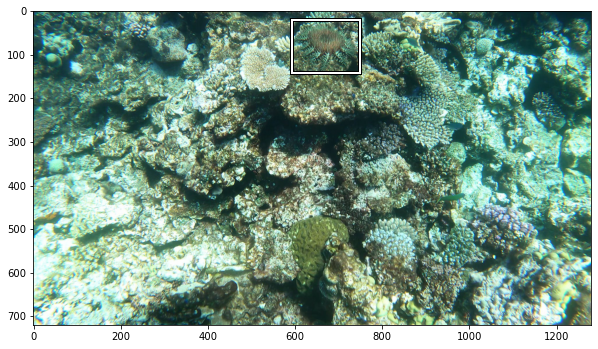

In [43]:
dataset.show_image(7322)